# Presenting the Problem
**Diabetes** is a disease that occurs either when the pancreas does not produce enough insulin or when the body can not effectively use the insulin it produces. **Insulin** is the hormone that reduces the glucose in the blood by acting on the entry of that glucose into the cell.

As people with diabetes can not produce sufficient insulin. they have to receive daily insulin injections to maintain normal blood glucose levels. However, this doses are not gradual and can cause many side effects.

Therefore, it is needed a more robust approach to this problem.


## Closed Loop Control
Recently, the availability of new products such as Continuous Glucose Monitors (CGM) and Insulin Pumps created the possibility of a Closed Loop System.

!["CGM and Insulin Pump"](https://i.imgur.com/m3g9iI5.png)


# Obtaining the Data
First, we need to collect the data used to solve our problem.

![https://www.openhumans.org/about/](https://i.imgur.com/ifP5jG2.png "Open Humans Logo")

>Open Humans is a platform that allows you to upload, connect, and privately store your personal data – such as genetic, activity, or social media data. Once you've added data, you can choose to donate it: you might choose to share some publicly , and you can join and contribute to diverse research projects.

# Data Inspection
Now, let's take a look in the data.

In [1023]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np

In [1024]:
#data = pd.read_json('data2\\entries__to_2017-10-01.json')
entries = pd.read_csv('entries_combined.json', low_memory=False)
print(entries.shape)
entries.head()


(644258, 22)


,id,_id,date,dateString,delta,device,direction,display_time,filtered,glucose,...,noise,rssi,scale,sgv,slope,sysTime,system_time,trend_arrow,type,unfiltered
0,0,5a8a12774594dc43b99e99a7,2018-02-18 23:55:33.613,2018-02-18T18:55:33.613000-05:00,NaN,xDrip-DexbridgeWixel,SingleUp,NaN,218688.0,229.0,...,1.0,100.0,NaN,229.0,NaN,NaN,NaN,NaN,sgv,234784.0
1,1,5a8a12774594dc43b99e99a7,2018-02-18 23:55:33.613,2018-02-18T18:55:33.613-0500,NaN,xDrip-DexbridgeWixel,SingleUp,NaN,218688.0,NaN,...,1.0,100.0,NaN,229.0,NaN,NaN,NaN,NaN,sgv,234784.0
2,2,5a8a114b4594dc43b99e99a4,2018-02-18 23:50:33.880,2018-02-18T18:50:33.880-0500,NaN,xDrip-DexbridgeWixel,Flat,NaN,209568.0,NaN,...,1.0,100.0,NaN,215.0,NaN,NaN,NaN,NaN,sgv,220736.0
3,3,5a8a101f4594dc43b99e99a1,2018-02-18 23:45:34.112,2018-02-18T18:45:34.112000-05:00,NaN,xDrip-DexbridgeWixel,SingleUp,NaN,200864.0,211.0,...,1.0,100.0,NaN,211.0,NaN,NaN,NaN,NaN,sgv,216608.0
4,4,5a8a101f4594dc43b99e99a1,2018-02-18 23:45:34.112,2018-02-18T18:45:34.112-0500,NaN,xDrip-DexbridgeWixel,SingleUp,NaN,200864.0,NaN,...,1.0,100.0,NaN,211.0,NaN,NaN,NaN,NaN,sgv,216608.0


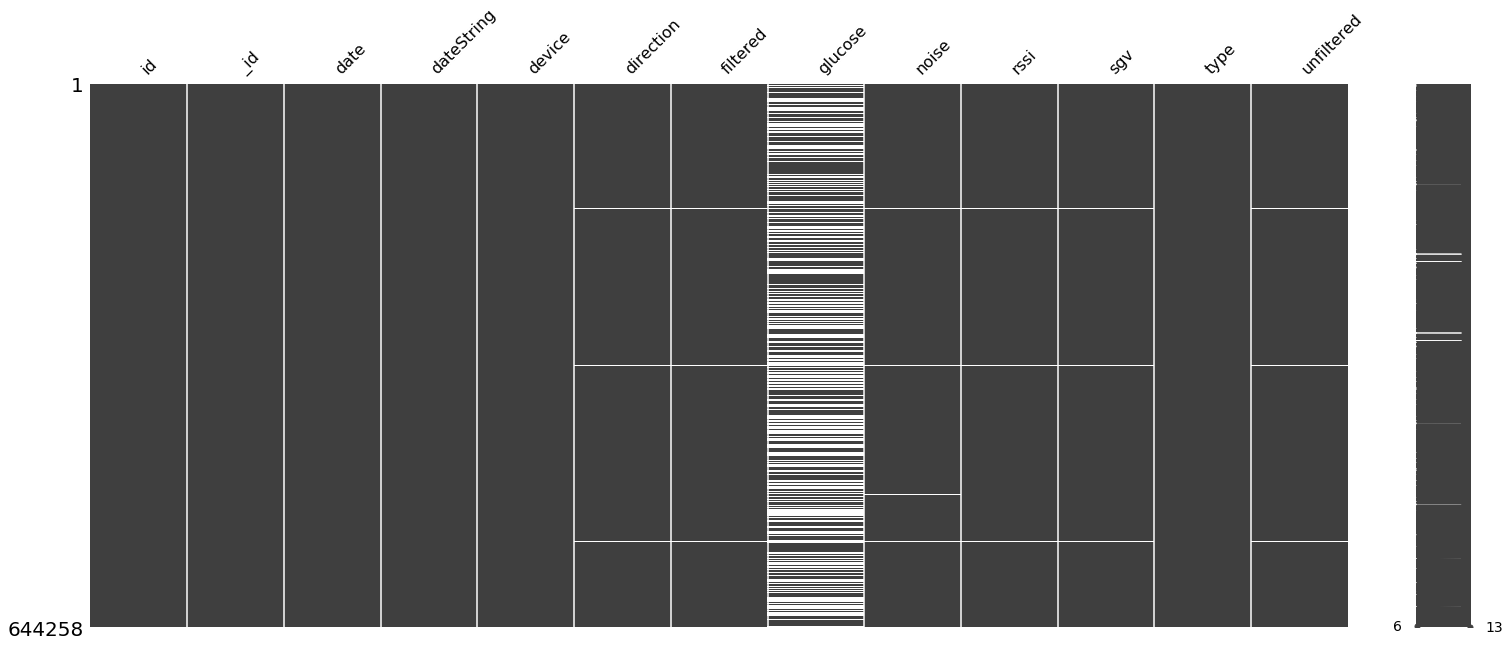

In [1032]:
# missing data
check = entries.dropna(how='any', axis=1, thresh=10000)
msno.matrix(check)

In [3]:
entries.dtypes

id                int64
_id              object
date             object
dateString       object
delta           float64
device           object
direction        object
display_time     object
filtered        float64
glucose         float64
intercept       float64
mbg             float64
noise           float64
rssi            float64
scale           float64
sgv             float64
slope           float64
sysTime          object
system_time      object
trend_arrow      object
type             object
unfiltered      float64
dtype: object

In [4]:
entries.isnull().sum()

id                   0
_id                  0
date                 0
dateString           0
delta           643834
device               0
direction         4264
display_time    643058
filtered          4304
glucose         303058
intercept       642128
mbg             642124
noise             5464
rssi              4304
scale           642128
sgv               4264
slope           642128
sysTime         643834
system_time     643058
trend_arrow     643058
type                 0
unfiltered        4304
dtype: int64

In [33]:
# Data of interest
bg_data = entries[['date', 'glucose', 'filtered', 'unfiltered']]
print(bg_data.shape)
bg_data.head()

(644258, 4)


,date,glucose,filtered,unfiltered
0,2018-02-18 23:55:33.613,229.0,218688.0,234784.0
1,2018-02-18 23:55:33.613,NaN,218688.0,234784.0
2,2018-02-18 23:50:33.880,NaN,209568.0,220736.0
3,2018-02-18 23:45:34.112,211.0,200864.0,216608.0
4,2018-02-18 23:45:34.112,NaN,200864.0,216608.0


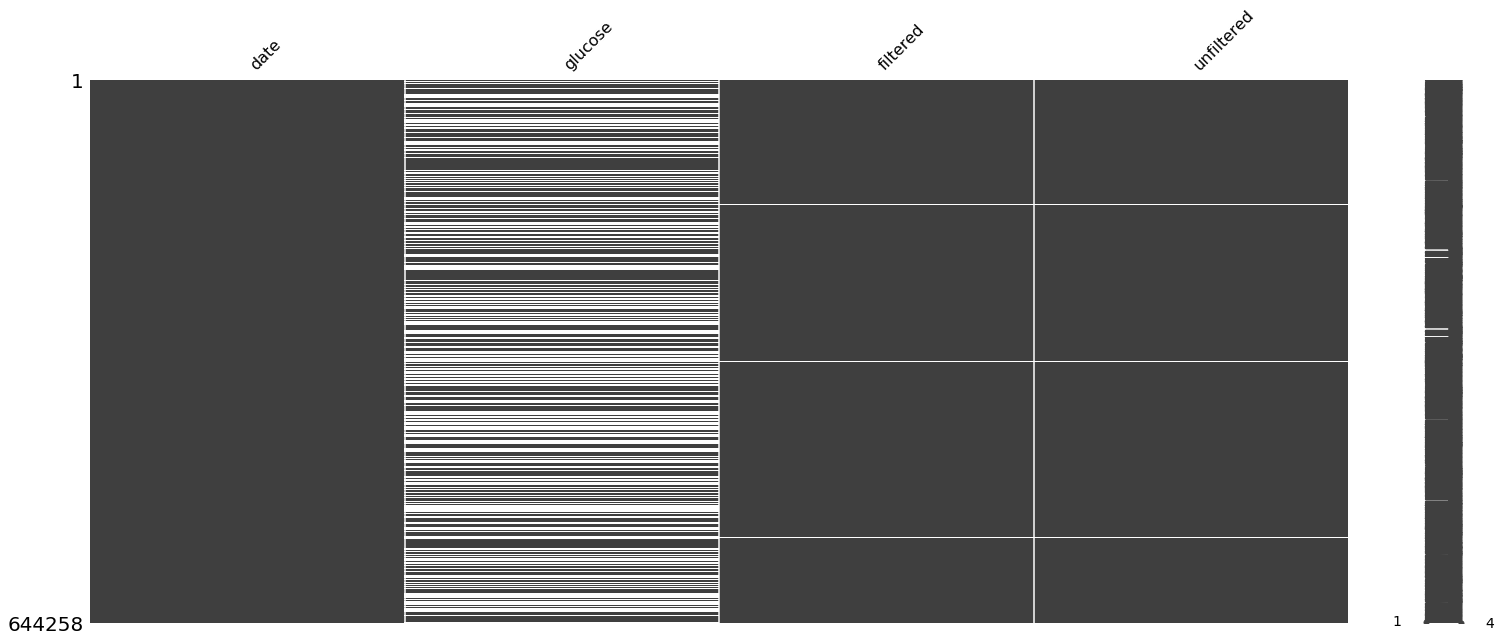

In [34]:
# missing data
msno.matrix(bg_data)

In [35]:
# Remove Duplicates
bg_data = bg_data.drop_duplicates()
print(bg_data.shape)
bg_data.head()

(215444, 4)


,date,glucose,filtered,unfiltered
0,2018-02-18 23:55:33.613,229.0,218688.0,234784.0
1,2018-02-18 23:55:33.613,NaN,218688.0,234784.0
2,2018-02-18 23:50:33.880,NaN,209568.0,220736.0
3,2018-02-18 23:45:34.112,211.0,200864.0,216608.0
4,2018-02-18 23:45:34.112,NaN,200864.0,216608.0


In [36]:
bg_data['date'] = pd.to_datetime(bg_data.date)
bg_data = bg_data.set_index('date')
bg_data.sort_index(inplace=True)
bg_data.head()

,glucose,filtered,unfiltered
date,,,
2017-04-26 18:25:42.269,NaN,49808.0,50832.0
2017-04-26 18:30:42.606,NaN,49448.0,51288.0
2017-04-27 01:10:42.345,NaN,51600.0,51128.0
2017-04-27 01:13:31.869,NaN,NaN,NaN
2017-04-27 01:15:42.345,NaN,50840.0,48088.0


In [37]:
# Drop NaN
bg_data = bg_data.dropna()
print(bg_data.shape)
bg_data.head()

(99881, 3)


,glucose,filtered,unfiltered
date,,,
2017-04-27 02:35:42.344,127.0,46784.0,51648.0
2017-04-27 02:40:42.329,126.0,48312.0,50472.0
2017-04-27 02:45:42.335,138.0,51704.0,59616.0
2017-04-27 03:10:41.556,133.0,53296.0,55960.0
2017-04-27 03:20:41.339,116.0,53512.0,43168.0


# EDA
Now, let explore the data with visualizations.

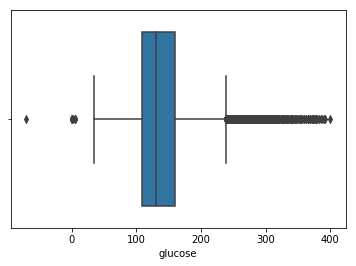

In [43]:
sns.boxplot(bg_data.glucose)

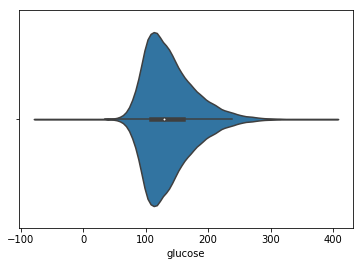

In [40]:

sns.violinplot(bg_data.glucose)

In [38]:
bg_data.describe()

,glucose,filtered,unfiltered
count,99881.000000,9.988100e+04,9.988100e+04
mean,137.733603,1.511858e+05,1.507464e+05
std,41.125953,6.125313e+04,4.930576e+04
min,-71.000000,1.260000e+02,0.000000e+00
25%,108.000000,1.196160e+05,1.196406e+05
50%,130.000000,1.452800e+05,1.453440e+05
75%,160.000000,1.769600e+05,1.772800e+05
max,400.000000,2.096896e+06,1.048448e+06


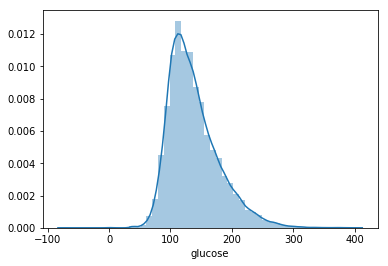

In [44]:
sns.distplot(bg_data.glucose)

In [45]:
bg_data.glucose.sort_values().head(15)

date
2017-08-07 21:45:21.830   -71.0
2017-06-21 11:59:53.377     0.0
2018-06-21 10:35:43.197     0.0
2017-06-05 23:00:28.422     0.0
2017-11-20 12:09:12.658     0.0
2018-01-07 22:27:39.265     0.0
2017-07-05 14:54:21.020     0.0
2017-05-04 14:00:17.375     0.0
2017-08-26 20:37:24.663     0.0
2017-12-16 16:19:21.000     5.0
2017-12-16 16:29:20.000     5.0
2017-12-16 16:34:20.000     5.0
2017-12-16 16:24:20.000     5.0
2018-05-19 21:22:03.017    35.0
2017-05-31 07:33:17.406    38.0
Name: glucose, dtype: float64

In [46]:
bg_data.glucose.sort_values(ascending=False).head(15)

date
2017-12-16 01:48:55.545    400.0
2018-03-09 03:39:51.161    392.0
2018-03-09 03:29:51.290    391.0
2018-03-09 03:24:51.286    390.0
2018-03-09 03:44:51.279    387.0
2018-03-09 03:19:51.271    385.0
2018-06-30 20:05:21.965    383.0
2018-03-09 03:49:51.282    382.0
2018-06-30 20:10:21.977    379.0
2018-06-30 19:55:21.969    378.0
2018-03-09 03:54:51.278    378.0
2018-03-09 03:14:51.281    378.0
2018-03-09 03:09:50.451    377.0
2018-03-09 03:59:51.293    375.0
2017-10-21 03:35:20.601    375.0
Name: glucose, dtype: float64

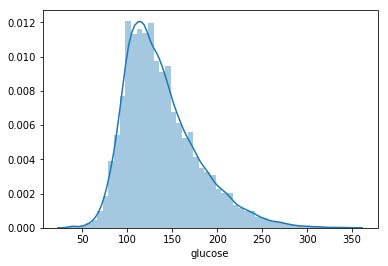

In [48]:
# Remove Outliers
bg_data = bg_data[(bg_data.glucose > 20) & (bg_data.glucose < 350)]
sns.distplot(bg_data.glucose)

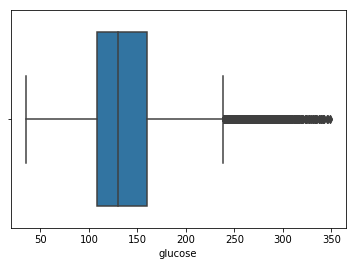

In [49]:
sns.boxplot(bg_data.glucose)

In [99]:
bg_data.shape

(99811, 1)

In [50]:
bg_data.index

DatetimeIndex(['2017-04-27 02:35:42.344000', '2017-04-27 02:40:42.329000',
               '2017-04-27 02:45:42.335000', '2017-04-27 03:10:41.556000',
               '2017-04-27 03:20:41.339000', '2017-04-27 03:25:41.341000',
               '2017-04-27 03:30:41.518000', '2017-04-27 03:35:41.337000',
               '2017-04-27 03:40:41.338000', '2017-04-27 03:45:41.342000',
               ...
               '2018-07-13 10:19:51.963000', '2018-07-13 10:29:51.952000',
               '2018-07-13 10:39:51.959000', '2018-07-13 11:04:51.167000',
               '2018-07-13 17:24:52.960000', '2018-07-13 17:49:50.668000',
               '2018-07-13 18:29:50.843000', '2018-07-13 19:09:50.964000',
               '2018-07-13 19:19:50.968000', '2018-07-13 21:34:50.972000'],
              dtype='datetime64[ns]', name='date', length=99828, freq=None)

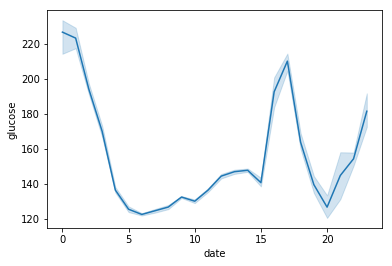

In [1038]:
# Example
day = bg_data['2017-06-30']
sns.lineplot(day.index.hour, day.glucose)

In [108]:
# Other data
treatments = pd.read_csv('treatments_combined.json', low_memory=False)
print(treatments.shape)
treatments.head()

(251298, 45)


,Unnamed: 0,CMR,Site-change,_body,_date,_description,_head,_id,_type,absolute,...,tail,targetBottom,targetTop,temp,timeFormat,timestamp,type,units,uuid,wizard
0,0,NaN,NaN,NaN,NaN,NaN,NaN,5a8a5722b08ad27a969f7086,NaN,1.250,...,NaN,NaN,NaN,NaN,NaN,2018-02-19 04:47:53,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,5a8a52e9b08ad27a969dfdea,NaN,1.150,...,NaN,NaN,NaN,NaN,NaN,2018-02-19 04:29:57,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,5a8a5181b08ad27a969d8405,NaN,0.625,...,NaN,NaN,NaN,NaN,NaN,2018-02-19 04:23:38,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,5a8a09e9b08ad27a968bd1ba,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,IFTTT-button,NaN,NaN,NaN,NaN,NaN,5a8a076bb08ad27a968b668a,NaN,NaN,...,NaN,75.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
treatments.dtypes

Unnamed: 0        int64
CMR              object
Site-change      object
_body            object
_date            object
_description     object
_head            object
_id              object
_type            object
absolute        float64
amount          float64
appended         object
bg              float64
bolus            object
boluscalc        object
carbs           float64
changed          object
created_at       object
duration        float64
enteredBy        object
eventType        object
fixed           float64
glucose         float64
glucoseType      object
insulin         float64
maxBasal        float64
medtronic        object
notes            object
preBolus        float64
rate             object
ratio           float64
raw_duration     object
raw_rate         object
reason           object
stale            object
tail            float64
targetBottom    float64
targetTop       float64
temp             object
timeFormat       object
timestamp        object
type            

In [123]:
treatments.dropna(axis=1, how='all', inplace=True)

In [124]:
treatments.columns

Index(['Unnamed: 0', 'CMR', 'Site-change', '_body', '_date', '_description',
       '_head', '_id', '_type', 'absolute', 'amount', 'appended', 'bg',
       'bolus', 'boluscalc', 'carbs', 'changed', 'created_at', 'duration',
       'enteredBy', 'eventType', 'fixed', 'glucose', 'glucoseType', 'insulin',
       'maxBasal', 'medtronic', 'notes', 'preBolus', 'rate', 'ratio',
       'raw_duration', 'raw_rate', 'reason', 'stale', 'tail', 'targetBottom',
       'targetTop', 'temp', 'timeFormat', 'timestamp', 'type', 'units', 'uuid',
       'wizard'],
      dtype='object')

In [125]:
treatments.eventType.value_counts()

Temp Basal          178802
Correction Bolus     55846
Note                  4856
<none>                2732
BG Check              1460
Temporary Target      1342
Meal Bolus            1240
Site Change            366
Carb Correction        124
Sensor Start            70
Insulin Change          34
Bolus Wizard            20
Sensor Change            4
Snack Bolus              4
Name: eventType, dtype: int64

In [129]:
treatments[treatments.eventType == 'Meal Bolus'].bg

10768      12.3
10780       7.3
13364       6.8
24629       9.5
28288      11.7
28552      12.8
39350      12.3
39362       7.3
41946       6.8
53211       9.5
56870      11.7
57134      12.8
57446     103.0
57487     123.0
57501     114.0
57619      72.0
57623      76.0
57689      61.0
57712      60.0
57808      57.0
57813      61.0
57851      61.0
57890      64.0
57981     109.0
58026      62.0
58076      66.0
58104      77.0
58223      73.0
58290     112.0
58303      74.0
          ...  
175121      6.8
186386      9.5
190045     11.7
190309     12.8
196435      5.9
201624     10.7
215751      5.2
216561      8.4
217012     14.0
218011     11.4
218022      4.8
218613      6.5
219145      8.2
219147      6.8
219912     14.7
219914     11.5
219919     10.5
226914      5.9
232103     10.7
246230      5.2
247040      8.4
247491     14.0
248490     11.4
248501      4.8
249092      6.5
249624      8.2
249626      6.8
250391     14.7
250393     11.5
250398     10.5
Name: bg, Length: 1240, 

In [118]:
treatments.isnull().sum()

Unnamed: 0           0
CMR             249958
Site-change     251006
_body           251232
_date           245094
_description    245094
_head           245094
_id                  0
_type           245094
absolute         72496
amount          248774
appended        251258
bg              249958
bolus           194222
boluscalc       251284
carbs           242774
changed         251258
created_at           0
duration         13428
enteredBy         1638
eventType         4398
fixed           250596
glucose         248458
glucoseType     248458
insulin         191446
maxBasal        251284
medtronic         9164
notes           188320
preBolus        251292
rate             72480
ratio           249958
raw_duration     72500
raw_rate         72500
reason          245626
stale           251258
tail            251258
targetBottom    250024
targetTop       250024
temp            251286
timeFormat      251294
timestamp         6414
type            250596
units           251148
uuid       

In [119]:
treatments.dropna(axis=1, thresh=10000)

,Unnamed: 0,_id,absolute,bolus,created_at,duration,enteredBy,eventType,insulin,medtronic,notes,rate,raw_duration,raw_rate,timestamp
0,0,5a8a5722b08ad27a969f7086,1.250,NaN,2018-02-19 04:47:53.000,30.0,EY209W,Temp Basal,NaN,mm://openaps/mm-format-ns-treatments/Temp Basal,NaN,1.25,{'_description': 'TempBasalDuration 2018-02-18...,{'_description': 'TempBasal 2018-02-18T23:47:5...,2018-02-19 04:47:53
1,1,5a8a52e9b08ad27a969dfdea,1.150,NaN,2018-02-19 04:29:57.000,30.0,EY209W,Temp Basal,NaN,mm://openaps/mm-format-ns-treatments/Temp Basal,NaN,1.15,{'_description': 'TempBasalDuration 2018-02-18...,{'_description': 'TempBasal 2018-02-18T23:29:5...,2018-02-19 04:29:57
2,2,5a8a5181b08ad27a969d8405,0.625,NaN,2018-02-19 04:23:38.000,30.0,EY209W,Temp Basal,NaN,mm://openaps/mm-format-ns-treatments/Temp Basal,NaN,0.625,{'_description': 'TempBasalDuration 2018-02-18...,{'_description': 'TempBasal 2018-02-18T23:23:3...,2018-02-19 04:23:38
3,3,5a8a09e9b08ad27a968bd1ba,NaN,NaN,2018-02-18 23:19:05.119,NaN,AAOXSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5a8a076bb08ad27a968b668a,NaN,NaN,2018-02-18 23:08:27.957,120.0,NaN,Temporary Target,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,5a8a4dfcb08ad27a969c5215,1.350,NaN,2018-02-19 04:08:22.000,30.0,EY209W,Temp Basal,NaN,mm://openaps/mm-format-ns-treatments/Temp Basal,NaN,1.35,{'_description': 'TempBasalDuration 2018-02-18...,{'_description': 'TempBasal 2018-02-18T23:08:2...,2018-02-19 04:08:22
6,6,5a8a4b2eb08ad27a969b634d,0.625,NaN,2018-02-19 03:56:29.000,30.0,EY209W,Temp Basal,NaN,mm://openaps/mm-format-ns-treatments/Temp Basal,NaN,0.625,{'_description': 'TempBasalDuration 2018-02-18...,{'_description': 'TempBasal 2018-02-18T22:56:2...,2018-02-19 03:56:29
7,7,5a8a4b2eb08ad27a969b634f,NaN,"{'programmed': 0.1, '_description': 'Bolus 201...",2018-02-19 03:54:08.000,0.0,EY209W,Correction Bolus,0.1,mm://openaps/mm-format-ns-treatments/Correctio...,"Normal bolus (solo, no bolus wizard).\r\nProgr...",NaN,NaN,NaN,2018-02-19 03:54:08
8,8,5a8a4b2eb08ad27a969b6351,1.100,NaN,2018-02-19 03:53:42.000,30.0,EY209W,Temp Basal,NaN,mm://openaps/mm-format-ns-treatments/Temp Basal,NaN,1.1,{'_description': 'TempBasalDuration 2018-02-18...,{'_description': 'TempBasal 2018-02-18T22:53:4...,2018-02-19 03:53:42
9,9,5a8a491cb08ad27a969ab558,0.625,NaN,2018-02-19 03:48:11.000,30.0,EY209W,Temp Basal,NaN,mm://openaps/mm-format-ns-treatments/Temp Basal,NaN,0.625,{'_description': 'TempBasalDuration 2018-02-18...,{'_description': 'TempBasal 2018-02-18T22:48:1...,2018-02-19 03:48:11


In [117]:
# Data of interest
exercise_data = treatments.loc[missing <20000]
print(exercise_data.shape)
exercise_data.head(15)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

In [129]:
# Pytorch
import torch
from torch import nn
import torch.nn.functional as F

# Sequential Models
Sequence models can make use of sequential information, which is a perfect case for our problem.
> Another way to think about this type of model is that they have a “memory” which captures information about what has been calculated so far.In theory, sequence models can make use of information in arbitrarily long sequences.

There are 3 principal models:
 - RNN
 - LSTM
 - GRU

## Prepare the Data
Before, apply the sequential data to the RNN, two conditions should be fulfilled: 
 1. Time data should be equally spaced and without missing values.
 2. The target values should be created by shifting the time series.

In [281]:
# Prepare the data as equaly spaced data
data = bg_data[['glucose']].resample('5Min').mean()
data = data.interpolate('linear')
print(data.isnull().sum())
print(data.shape)

data.head()


glucose    0
dtype: int64
(127524, 1)


,glucose
date,
2017-04-27 02:35:00,127.0
2017-04-27 02:40:00,126.0
2017-04-27 02:45:00,138.0
2017-04-27 02:50:00,137.0
2017-04-27 02:55:00,136.0


In [1033]:
# Create target for each value
data['target'] = data.glucose.shift(1)
print(data.shape)

data.head()

(127524, 2)


,glucose,target
date,,
2017-04-27 02:35:00,127.0,NaN
2017-04-27 02:40:00,126.0,127.0
2017-04-27 02:45:00,138.0,126.0
2017-04-27 02:50:00,137.0,138.0
2017-04-27 02:55:00,136.0,137.0


In [698]:
data['2018-06-20']

,glucose
date,
2018-06-20 00:00:00,71.000000
2018-06-20 00:05:00,73.000000
2018-06-20 00:10:00,79.500000
2018-06-20 00:15:00,86.000000
2018-06-20 00:20:00,92.000000
2018-06-20 00:25:00,92.250000
2018-06-20 00:30:00,92.500000
2018-06-20 00:35:00,92.750000
2018-06-20 00:40:00,93.000000


In [283]:
data.to_csv('time_series.csv')

In [284]:
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    
    batch_size_total = batch_size * seq_length
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [285]:
batches = get_batches(data.values, 32, 288)
x, y = next(batches)

In [286]:
x = x[:,:,np.newaxis]
print(x.shape)
x[1,:5,:]

(32, 288, 1)


array([[143.375],
       [142.5  ],
       [142.   ],
       [140.   ],
       [138.5  ]])

In [287]:
y = y[:,:,np.newaxis]
print(y.shape)
y[1,:5,:]

(32, 288, 1)


array([[142.5],
       [142. ],
       [140. ],
       [138.5],
       [138. ]])

# RNN
![](https://i.imgur.com/ZHkeHte.png)


In [1006]:
# Model
class RNN(nn.Module):
    def __init__(self, input_size, output_size, n_hidden, n_layers, drop_prob=0.5):
        super(RNN, self).__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.n_input = input_size
        self.output_size = output_size
        self.drop_prob = drop_prob
        self.name = 'RNN'

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, n_hidden, n_layers, batch_first=True, dropout=drop_prob)
        
        # last, fully-connected layer
        self.fc = nn.Linear(n_hidden, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.contiguous().view(-1, self.n_hidden)  
        
        # get final output 
        output = self.fc(r_out)
        #output.view(batch_size, -1, self.output_size)
        
        return output, hidden
    

In [760]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [761]:
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=32, n_layers=2)
test_rnn

RNN(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [762]:
batches = get_batches(data.values, 32, 288)
x, y = next(batches)
x = x[:,:,np.newaxis]

# test that dimensions are as expected00
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=128, n_layers=2)

test_input = torch.Tensor(x) # give it a batch_size of 1 as first dimension

print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([32, 288, 1])
Output size:  torch.Size([9216, 1])
Hidden state size:  torch.Size([2, 32, 128])


In [936]:
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: RNN network
        data: data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Sequence length
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # create training and validation data
    val_idx = int(len(data) * (1 - val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if(train_on_gpu):
        net.cuda()
    
    # Best Loss
    best_avg_loss = np.infty
    counter = 0
    for e in range(epochs):
        # initialize hidden state
        h = None#net.init_hidden(batch_size)

        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1
            
            # Reshape inputs and targets
            x = x[:, :, np.newaxis]
            y = y[:, :, np.newaxis]
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()
            
            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs.float(), h)
            
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            if isinstance(h, tuple):
                h = tuple([each.data for each in h])
            else:
                h = h.data
            
            # calculate the loss and perform backprop
            loss = criterion(output.squeeze(), targets.view(batch_size * seq_length).float())
            
            loss.backward()
            
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = None#net.init_hidden(batch_size)
                val_losses = []
                
                net.eval()
                
                for x_val, y_val in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them Torch tensors
                    x_val = x_val[:, :, np.newaxis]
                    y_val = y_val[:, :, np.newaxis]
                    x_val, y_val = torch.from_numpy(x), torch.from_numpy(y)
                    
                    inputs, targets = x_val, y_val
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs.float(), val_h)
                    
                    val_loss = criterion(output.squeeze(), targets.view(batch_size * seq_length).float())
                
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                # Saves if val loss reduced
                new_val_loss = np.mean(val_losses)
                save_model = new_val_loss <= best_avg_loss
                
                if save_model:
                    # change the name, for saving multiple files
                    model_name = str(net.name) + 'rnn_epoch_' + str(e) + '.net'

                    checkpoint = {'n_hidden': net.n_hidden,
                                  'n_layers': net.n_layers,
                                  'state_dict': net.state_dict(),
                                  'n_input':net.n_input
                                  }

                    with open(model_name, 'wb') as f:
                        torch.save(checkpoint, f)
                    # updated best loss
                    best_avg_loss = new_val_loss
                
                print("Epoch: {}/{}...".format(e + 1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(new_val_loss),
                      "Model Saved: {}".format(save_model))


In [881]:
# define and print the net
input_size = 1
output_size = 1
n_hidden = 512
n_layers = 2

net = RNN(input_size, output_size, n_hidden, n_layers)
print(net)

RNN(
  (rnn): RNN(1, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)


In [912]:
batch_size = 16
seq_length = 288
n_epochs = 150 

# train the model
train(net, data.values, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, val_frac=.15,lr=0.001, print_every=100)

Epoch: 5/150... Step: 100... Loss: 28.0725... Val Loss: 29.1613 Model Saved: True
Epoch: 9/150... Step: 200... Loss: 33.9772... Val Loss: 36.0495 Model Saved: False
Epoch: 14/150... Step: 300... Loss: 79.1104... Val Loss: 75.1161 Model Saved: False
Epoch: 18/150... Step: 400... Loss: 28.5554... Val Loss: 38.1136 Model Saved: False
Epoch: 22/150... Step: 500... Loss: 46.8695... Val Loss: 48.1249 Model Saved: False
Epoch: 27/150... Step: 600... Loss: 47.9301... Val Loss: 49.0420 Model Saved: False
Epoch: 31/150... Step: 700... Loss: 42.1913... Val Loss: 41.8323 Model Saved: False
Epoch: 35/150... Step: 800... Loss: 48.4234... Val Loss: 50.9759 Model Saved: False
Epoch: 40/150... Step: 900... Loss: 52.7956... Val Loss: 54.3055 Model Saved: False
Epoch: 44/150... Step: 1000... Loss: 23.3191... Val Loss: 23.8351 Model Saved: True
Epoch: 48/150... Step: 1100... Loss: 43.8034... Val Loss: 44.2792 Model Saved: False
Epoch: 53/150... Step: 1200... Loss: 51.5493... Val Loss: 53.0009 Model Saved:

In [913]:
def predict(net, inp, time_steps=5, h=None):
        ''' Given an input, predict the output for n_predicted timesteps.
            Returns the predicted output and the hidden state.
        '''
        net.eval()
        
        # Outputs
        outputs = []
        
        # Tensor inputs - all values as sequence
        inputs = torch.from_numpy(inp)
        inputs = inputs.view(1, -1, 1)
        
        if(train_on_gpu):
            inputs = inputs.cuda().float()
        
        for ii in range(time_steps):
            # get the output of the model
            out, h = net(inputs, h)
            value_out = out[-1].detach().cpu().numpy().squeeze()
            outputs.append(value_out)
            #print(out.size())
            # updates input
            inputs = out.view(1, -1, 1)
        
        # return the encoded value of the predicted char and the hidden state
        return outputs

In [944]:
start_date = '2018-06-20 00:00:00'
end_date = '2018-06-20 10:00:00'
initial_values = day[start_date:end_date]
time_steps = 60

In [945]:
# Predictions
predicted_values = predict(net, initial_values.values, time_steps, h=None)
# DateTime index of predictions
pred_index = pd.date_range(start=end_date, periods=time_steps, freq='5Min')

# Predictions as Series
predictions_series = pd.Series(predicted_values, index=pred_index).astype('int')

In [1013]:
# Plots
real_values = day[day.index.isin(pred_index)]
plot_df = pd.concat([initial_values, real_values, predictions_series], axis=1)
plot_df.columns = ['Initial Values', 'Real Values', 'RNN']
#plot_df = day.merge(initial_values)
#plot_df = plotdf.merge()
#plot_df.loc[end_date, 'Predictions'] = real_values[end_date]
plot_df.head()

,Initial Values,Real Values,RNN
date,,,
2018-06-20 00:00:00,71.0,NaN,NaN
2018-06-20 00:05:00,73.0,NaN,NaN
2018-06-20 00:10:00,79.5,NaN,NaN
2018-06-20 00:15:00,86.0,NaN,NaN
2018-06-20 00:20:00,92.0,NaN,NaN


In [947]:
plot_df.isnull().sum()

Initital Values     59
Real Values        120
RNN                120
dtype: int64

In [948]:
plot_df.dtypes

Initital Values    float64
Real Values        float64
RNN                float64
dtype: object

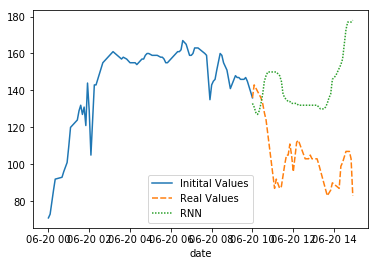

In [949]:
sns.lineplot(data=plot_df)
#plot_df.plot()

# LSTM

![](https://i.imgur.com/rNriLGv.png)

In [937]:
class LSTM(nn.Module):
    
    def __init__(self, input_size, output_size, n_hidden=256, n_layers=2,
                               drop_prob=0.5):
        super().__init__()
        self.n_input = input_size
        self.n_output = output_size
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.name = 'LSTM'
        
        ## TODO: define the LSTM
        self.lstm = nn.LSTM(input_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ## TODO: define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## TODO: define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, output_size)
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        ## TODO: Get the outputs and the new hidden state from the lstm
        r_output, hidden = self.lstm(x, hidden)
        
        ## TODO: pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)
        
        ## TODO: put x through the fully-connected layer
        out = self.fc(out)
        
        # return the final output and the hidden state
        return out, hidden
    

In [938]:
# define and print the net
input_size = 1
output_size = 1
n_hidden = 256
n_layers = 2

lstm = LSTM(input_size, output_size, n_hidden, n_layers, drop_prob=.5)
print(lstm)

LSTM(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [940]:
batch_size = 16
seq_length = 288
n_epochs = 250 # start smaller if you are just testing initial behavior

# train the model
train(lstm, data.values, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, val_frac=.15,lr=0.001, print_every=100)

Epoch: 5/250... Step: 100... Loss: 937.3339... Val Loss: 852.8977 Model Saved: True
Epoch: 9/250... Step: 200... Loss: 734.9344... Val Loss: 659.4532 Model Saved: True
Epoch: 14/250... Step: 300... Loss: 457.6614... Val Loss: 367.7971 Model Saved: True
Epoch: 18/250... Step: 400... Loss: 436.3925... Val Loss: 360.4458 Model Saved: True
Epoch: 22/250... Step: 500... Loss: 432.7799... Val Loss: 354.1247 Model Saved: True
Epoch: 27/250... Step: 600... Loss: 355.4623... Val Loss: 271.2172 Model Saved: True
Epoch: 31/250... Step: 700... Loss: 341.7371... Val Loss: 297.5770 Model Saved: False
Epoch: 35/250... Step: 800... Loss: 421.5574... Val Loss: 334.2065 Model Saved: False
Epoch: 40/250... Step: 900... Loss: 354.8755... Val Loss: 268.3491 Model Saved: True
Epoch: 44/250... Step: 1000... Loss: 186.6897... Val Loss: 78.1186 Model Saved: True
Epoch: 48/250... Step: 1100... Loss: 253.6881... Val Loss: 160.9742 Model Saved: False
Epoch: 53/250... Step: 1200... Loss: 323.4603... Val Loss: 231.

In [960]:
# Predictions
lstm_predicted_values = predict(lstm, initial_values.values, time_steps, h=None)

# Predictions as Series
lstm_predictions_series = pd.Series(lstm_predicted_values, index=pred_index).astype('int')

In [1014]:
# Plots

plot_df['LSTM'] = lstm_predictions_series
#plot_df = day.merge(initial_values)
#plot_df = plotdf.merge()
#plot_df.loc[end_date, 'Predictions'] = real_values[end_date]
plot_df.head()

,Initial Values,Real Values,RNN,LSTM
date,,,,
2018-06-20 00:00:00,71.0,NaN,NaN,NaN
2018-06-20 00:05:00,73.0,NaN,NaN,NaN
2018-06-20 00:10:00,79.5,NaN,NaN,NaN
2018-06-20 00:15:00,86.0,NaN,NaN,NaN
2018-06-20 00:20:00,92.0,NaN,NaN,NaN


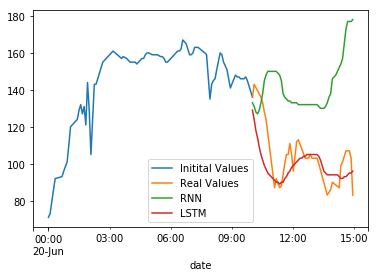

In [962]:
#sns.lineplot(plot_df)
plot_df.plot()

# GRU
![](https://i.imgur.com/DUnax65.png)

In [965]:
class GRU(nn.Module):
    
    def __init__(self, input_size, output_size, n_hidden=256, n_layers=2,
                               drop_prob=0.5):
        super().__init__()
        self.n_input = input_size
        self.n_output = output_size
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.name = 'GRU'
        
        ## TODO: define the LSTM
        self.gru = nn.GRU(input_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ## TODO: define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## TODO: define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, output_size)
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        ## TODO: Get the outputs and the new hidden state from the lstm
        r_output, hidden = self.gru(x, hidden)
        
        ## TODO: pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)
        
        ## TODO: put x through the fully-connected layer
        out = self.fc(out)
        
        # return the final output and the hidden state
        return out, hidden
    

In [966]:
# define and print the net
input_size = 1
output_size = 1
n_hidden = 256
n_layers = 2

gru = GRU(input_size, output_size, n_hidden, n_layers, drop_prob=.5)
print(gru)

GRU(
  (gru): GRU(1, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [968]:
batch_size = 8
seq_length = 288
n_epochs = 250 # start smaller if you are just testing initial behavior

# train the model
train(gru, data.values, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, val_frac=.15,lr=0.001, print_every=100)

Epoch: 3/250... Step: 100... Loss: 115.2587... Val Loss: 22.3271 Model Saved: True
Epoch: 5/250... Step: 200... Loss: 125.6841... Val Loss: 16.1986 Model Saved: True
Epoch: 7/250... Step: 300... Loss: 128.4845... Val Loss: 56.3936 Model Saved: False
Epoch: 9/250... Step: 400... Loss: 132.4942... Val Loss: 51.2306 Model Saved: False
Epoch: 11/250... Step: 500... Loss: 121.6540... Val Loss: 35.1857 Model Saved: False
Epoch: 13/250... Step: 600... Loss: 137.0219... Val Loss: 41.8895 Model Saved: False
Epoch: 15/250... Step: 700... Loss: 123.5374... Val Loss: 63.5951 Model Saved: False
Epoch: 18/250... Step: 800... Loss: 163.6803... Val Loss: 63.7569 Model Saved: False
Epoch: 20/250... Step: 900... Loss: 119.6910... Val Loss: 34.6056 Model Saved: False
Epoch: 22/250... Step: 1000... Loss: 112.4411... Val Loss: 18.9822 Model Saved: False
Epoch: 24/250... Step: 1100... Loss: 141.1550... Val Loss: 69.7099 Model Saved: False
Epoch: 26/250... Step: 1200... Loss: 124.0991... Val Loss: 39.8115 Mo

In [969]:
# Predictions
gru_predicted_values = predict(gru, initial_values.values, time_steps, h=None)

# Predictions as Series
gru_predictions_series = pd.Series(gru_predicted_values, index=pred_index).astype('int')

In [1015]:
# Plots

plot_df['GRU'] = gru_predictions_series
#plot_df = day.merge(initial_values)
#plot_df = plotdf.merge()
#plot_df.loc[end_date, 'Predictions'] = real_values[end_date]
plot_df.head()

,Initial Values,Real Values,RNN,LSTM,GRU
date,,,,,
2018-06-20 00:00:00,71.0,NaN,NaN,NaN,NaN
2018-06-20 00:05:00,73.0,NaN,NaN,NaN,NaN
2018-06-20 00:10:00,79.5,NaN,NaN,NaN,NaN
2018-06-20 00:15:00,86.0,NaN,NaN,NaN,NaN
2018-06-20 00:20:00,92.0,NaN,NaN,NaN,NaN


# Evaluating the models

(array([736865.   , 736865.125, 736865.25 , 736865.375, 736865.5  ,
        736865.625, 736865.75 , 736865.875, 736866.   ]),
 <a list of 9 Text xticklabel objects>)

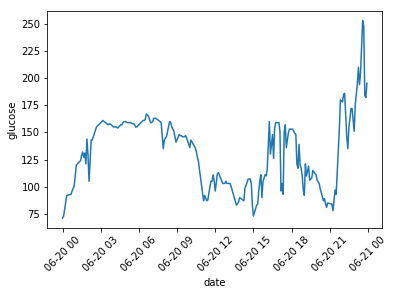

In [914]:
# initial values of 1 day
day = data['2018-06-20']
sns.lineplot(x=day.index, y=day.glucose)
plt.xticks(rotation=45)

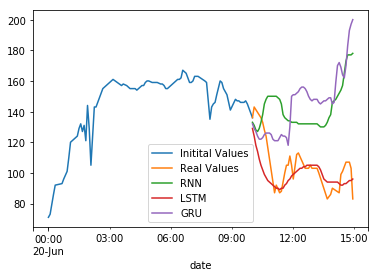

In [971]:
plot_df.plot()

# Best models

In [1019]:
import glob
def load_best(model_name='RNN'):
    # Here we have loaded in a model
    
    file_name = sorted(glob.glob(model_name + '*.net'))[-1]
    print("Best model found: {}".format(file_name))
    # Load file
    with open(file_name, 'rb') as f:
        checkpoint = torch.load(f)
    # Model info
    if model_name == 'RNN':
        # loaded = RNN(checkpoint['n_input'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
        loaded = RNN(1, 1, n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
    elif model_name == 'LSTM':
        loaded = LSTM(1, 1, n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
    elif model_name == 'GRU':
        loaded = GRU(1, 1, n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
    else:
        loaded = None
    try:
        loaded.load_state_dict(checkpoint['state_dict'])
        print("Loading weights...")
    except RuntimeError:
        print("Error!")
    
    return loaded

In [1020]:

best_rnn = load_best('RNN').cuda()
best_lstm = load_best('LSTM').cuda()
best_gru = load_best('GRU').cuda()

# Predictions
rnn_pred = predict(best_rnn, initial_values.values, time_steps, h=None)
lstm_pred = predict(best_lstm, initial_values.values, time_steps, h=None)
gru_pred = predict(best_gru, initial_values.values, time_steps, h=None)

# Predictions as Series
rnn_series = pd.Series(rnn_pred, index=pred_index).astype('int')
lstm_series = pd.Series(lstm_pred, index=pred_index).astype('int')
gru_series = pd.Series(gru_pred, index=pred_index).astype('int')


Best model found: RNNrnn_epoch_90.net
Loading weights...
Best model found: LSTMrnn_epoch_87.net
Loading weights...
Best model found: GRUrnn_epoch_93.net
Loading weights...


In [1021]:
plot_df['RNN_best'] = rnn_series
plot_df['LSTM_best'] = lstm_series
plot_df['GRU_best'] = gru_series

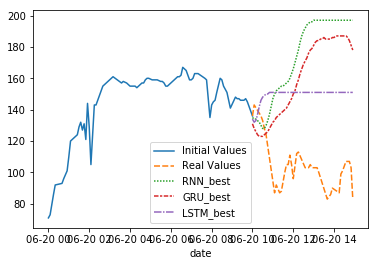

In [1022]:
sns.lineplot(data=plot_df[['Initial Values', 'Real Values', 'RNN_best', 'GRU_best', 'LSTM_best']])
#plot_df[['Initial Values', 'Real Values', 'RNN_best', 'GRU_best', 'LSTM_best']].plot()